<a href="https://colab.research.google.com/github/mariabandeira/Projeto_Final_IIA/blob/main/SentimentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk
from tqdm.notebook import tqdm
from collections import Counter

/home/erlo/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
from nltk import pos_tag
from nltk.tokenize import word_tokenize

nltk.download('punkt')  
nltk.download('maxent_ne_chunker') 
nltk.download('averaged_perceptron_tagger')
nltk.download('words')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /home/erlo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /home/erlo/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/erlo/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package words to /home/erlo/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to /home/erlo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/erlo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [4]:
import spacy
import string
import spacy.cli
spacy.cli.download("en_core_web_sm") 

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 15.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [7]:
from textblob import Word, TextBlob
from deep_translator import GoogleTranslator
import pandas as pd

In [97]:
from nrclex import NRCLex
from collections import Counter

## Sentiment Analysis

In [8]:
neg_df = pd.read_csv('datasets/NEGATIVE_B0BHZT5S12.csv', sep=';')
pos_df = pd.read_csv('datasets/POSITIVE_B0BHZT5S12.csv', sep=';')

In [9]:
neg_df.head(1)

,username,title,model,verified,date,region,text,stars,id
0,columbia93,Battery doesn't last very long & forget about ...,Digital Storage Capacity: 32 GBOffer Type: Wit...,Verified Purchase,"April 6, 2024",United States,\nThis is my 3rd Fire 10 Tablet. They have a r...,3.0,B0BHZT5S12


In [10]:
pos_df.head(1)

,username,title,model,verified,date,region,text,stars,id
0,Ace Knight,I Keep Buying Kindle Tablets! Incredibly Vers...,Digital Storage Capacity: 32 GBOffer Type: Wit...,Verified Purchase,"March 14, 2024",United States,\nI have a herd of Kindle Fire Tablets from ov...,5.0,B0BHZT5S12


In [11]:
df = (pd.concat([neg_df, pos_df], ignore_index=True)
     .assign(origem=lambda x: ['negative'] * len(neg_df) + ['positive'] * len(pos_df)))

In [12]:
df = df.sample(frac=1).reset_index(drop=True)
df.head(3)

,username,title,model,verified,date,region,text,stars,id,origem
0,KevinT,Not enough apps,Digital Storage Capacity: 32 GBOffer Type: Wit...,Verified Purchase,"April 11, 2024",United States,"\nNot enough apps, my daughter hates it but I ...",3.0,B0BHZT5S12,negative
1,SRK,Okay for its price,Digital Storage Capacity: 32 GBOffer Type: Wit...,Verified Purchase,"December 29, 2023",United States,\nPros -1. Lower price compared to iPad.2. Has...,3.0,B0BHZT5S12,negative
2,columbia93,Battery doesn't last very long & forget about ...,Digital Storage Capacity: 32 GBOffer Type: Wit...,Verified Purchase,"April 6, 2024",United States,\nThis is my 3rd Fire 10 Tablet. They have a r...,3.0,B0BHZT5S12,negative


### Introdução

In [13]:
PRODUCT_ID = df['id'].unique()[0]

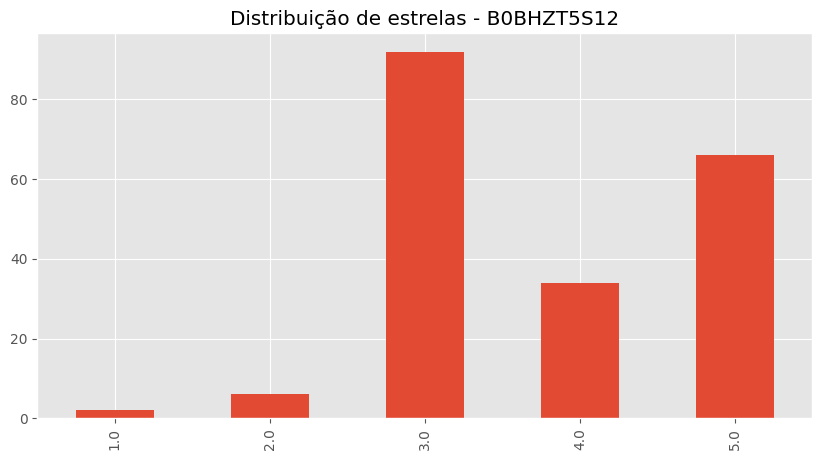

In [14]:
ax = df['stars'].value_counts().sort_index().plot(kind='bar',figsize=(10,5))
ax.set_xlabel('')
ax.set_title('Distribuição de estrelas - {}'.format(PRODUCT_ID))
plt.show()

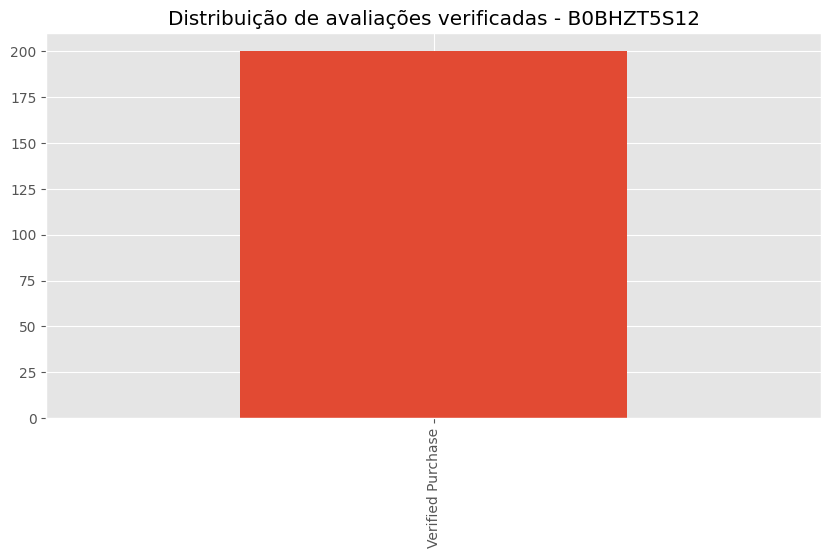

In [15]:
ax = df['verified'].value_counts().sort_index().plot(kind='bar', figsize=(10,5))
ax.set_xlabel('')
ax.set_title('Distribuição de avaliações verificadas - {}'.format(PRODUCT_ID))
plt.show()

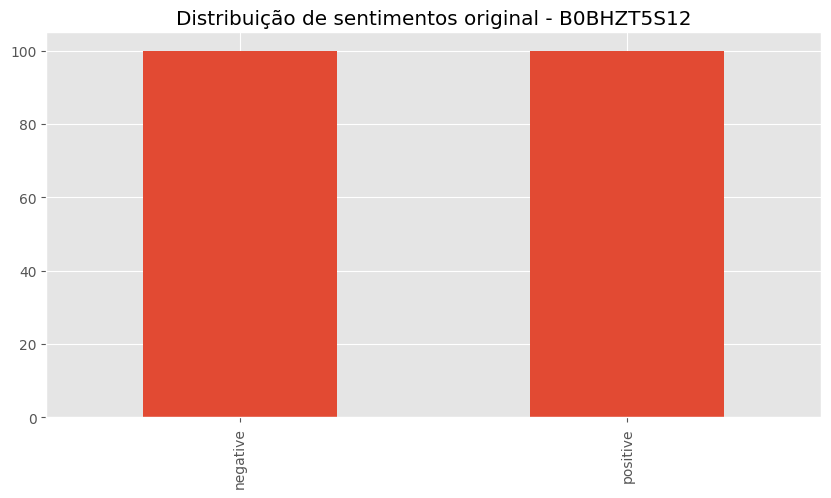

In [16]:
ax = df['origem'].value_counts().sort_index().plot(kind='bar', figsize=(10,5))
ax.set_xlabel('')
ax.set_title('Distribuição de sentimentos original - {}'.format(PRODUCT_ID))
plt.show()

### Pretrained Model

In [17]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

/home/erlo/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [18]:
def polarity_scores_roberta(example):
  encoded_text = tokenizer(example, return_tensors='pt') # output should be pytorch tensors(vectors)
  output = model(**encoded_text) # passing the enconded(tokenized) text into RoBERTa
  scores = output[0][0].detach().numpy()
  scores = softmax(scores) #converts the scores into probabilities
  scores_dict = {
    'roberta_neg': scores[0],
    'roberta_neu': scores[1],
    'roberta_pos': scores[2]
  }

  return scores_dict

In [19]:
df = df.rename(columns={'id': 'product_id'})

In [26]:
df['Id'] = df.index

In [27]:
df = df.dropna()

In [28]:
# Creates the roberta results DF
res = {}
for i, row in df.iterrows():
  try:
    text = row['text']
    myid = row['Id']
    roberta_result = polarity_scores_roberta(text)
    res[myid] = roberta_result
  except RuntimeError:
    print(f'Broke for id {myid}')

Broke for id 2
Broke for id 5
Broke for id 64
Broke for id 91
Broke for id 92
Broke for id 125
Broke for id 128


In [29]:
results_df = pd.DataFrame(res).T

In [30]:
results_df

,roberta_neg,roberta_neu,roberta_pos
0,0.922657,0.068516,0.008828
1,0.477187,0.392493,0.130321
3,0.015919,0.130102,0.853979
4,0.801570,0.162842,0.035588
6,0.112769,0.316301,0.570929
...,...,...,...
195,0.001441,0.007429,0.991131
196,0.013303,0.079591,0.907106
197,0.666389,0.235665,0.097946
198,0.738834,0.247023,0.014143


In [31]:
#results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'Id'})
results_df = results_df.merge(df, how='left')

In [32]:
results_df

,Id,roberta_neg,roberta_neu,roberta_pos,username,title,model,verified,date,region,text,stars,product_id,origem
0,0,0.922657,0.068516,0.008828,KevinT,Not enough apps,Digital Storage Capacity: 32 GBOffer Type: Wit...,Verified Purchase,"April 11, 2024",United States,"\nNot enough apps, my daughter hates it but I ...",3.0,B0BHZT5S12,negative
1,1,0.477187,0.392493,0.130321,SRK,Okay for its price,Digital Storage Capacity: 32 GBOffer Type: Wit...,Verified Purchase,"December 29, 2023",United States,\nPros -1. Lower price compared to iPad.2. Has...,3.0,B0BHZT5S12,negative
2,3,0.015919,0.130102,0.853979,C C,I love my Kindel,Digital Storage Capacity: 32 GBOffer Type: Wit...,Verified Purchase,"May 2, 2024",United States,\nIs only one thing it is not blue tooth I lik...,3.0,B0BHZT5S12,negative
3,4,0.801570,0.162842,0.035588,George H. Seidel Jr.,"Loved it, but the one I got was defective",Digital Storage Capacity: 32 GBOffer Type: Wit...,Verified Purchase,"April 18, 2024",United States,\nI loved this Kindle. But after a few weeks ...,5.0,B0BHZT5S12,positive
4,6,0.112769,0.316301,0.570929,R. D. Hoag,This is a great value,Digital Storage Capacity: 32 GBOffer Type: Wit...,Verified Purchase,"April 26, 2024",United States,\nExtremely inexpensive for what you get. Exce...,5.0,B0BHZT5S12,positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,195,0.001441,0.007429,0.991131,Amazon Customer,This is a great tablet.,Digital Storage Capacity: 32 GBOffer Type: Wit...,Verified Purchase,"April 2, 2024",United States,\nThis is a wonderful tablet. It is lightweigh...,5.0,B0BHZT5S12,positive
189,196,0.013303,0.079591,0.907106,Teevan,Great tablet for basic functions,Digital Storage Capacity: 32 GBOffer Type: Wit...,Verified Purchase,"April 23, 2024",United States,\nGreat if you need something for web browsing...,5.0,B0BHZT5S12,positive
190,197,0.666389,0.235665,0.097946,Just Saying,Not much faster than my 2017 Fire HD 10 that I...,Digital Storage Capacity: 32 GBOffer Type: Wit...,Verified Purchase,"January 11, 2024",United States,\nThe price on sale makes this a no brainer. ...,3.0,B0BHZT5S12,negative
191,198,0.738834,0.247023,0.014143,drwmjohns,Some apps are not available to be downloaded 😕,Digital Storage Capacity: 64 GBOffer Type: Wit...,Verified Purchase,"March 13, 2024",United States,\nWas not able to download the Filament Bible ...,3.0,B0BHZT5S12,negative


In [33]:
results_df['roberta_pos'].sum()

89.77585

In [34]:
results_df['roberta_neu'].sum()

42.408447

In [35]:
results_df['roberta_neg'].sum()

60.8157

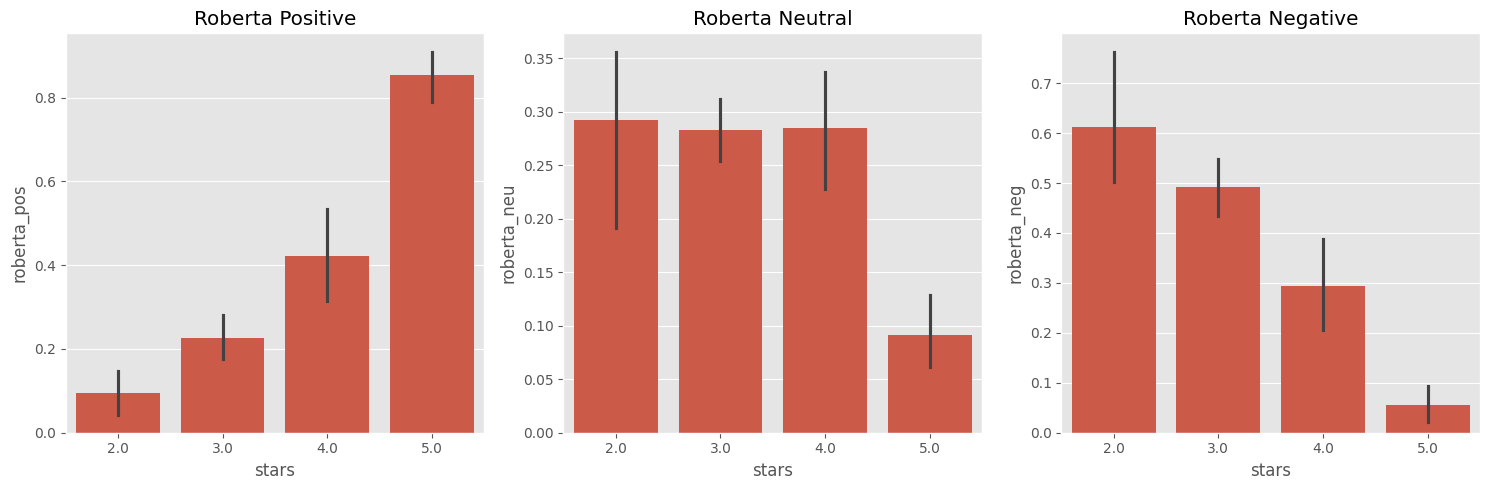

In [36]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
sns.barplot(data=results_df, x='stars', y='roberta_pos', ax=axs[0])
sns.barplot(data=results_df, x='stars', y='roberta_neu', ax=axs[1])
sns.barplot(data=results_df, x='stars', y='roberta_neg', ax=axs[2])
axs[0].set_title('Roberta Positive')
axs[1].set_title('Roberta Neutral')
axs[2].set_title('Roberta Negative')
plt.tight_layout()
plt.show()

In [37]:
positive_text = []
negative_text = []

In [38]:
for index, row in results_df.iterrows():
    if row['roberta_neg'] > row['roberta_pos']:
        negative_text.append(row['text'])
    else:
        positive_text.append(row['text'])

positive_text = ' '.join(positive_text)

negative_text = ' '.join(negative_text)

In [39]:
positive_text = positive_text.lower()
negative_text = negative_text.lower()

In [40]:
nlp = spacy.load('en_core_web_sm')
doc_p = nlp(positive_text) #positive doc
doc_n = nlp(negative_text) #negative doc

In [41]:
# adding adjectives only restriction
pos_nonAdjs = [token.text for token in doc_p if token.pos_ != "ADJ"]
neg_nonAdjs = [token.text for token in doc_n if token.pos_ != "ADJ"]

pos_Adjs = [token.text for token in doc_p if token.pos_ == "ADJ"]
neg_Adjs = [token.text for token in doc_n if token.pos_ == "ADJ"]

In [42]:
stopwords = nltk.corpus.stopwords.words('english')
punctuation = string.punctuation

In [43]:
wp = Word(positive_text)
lemma_pos = TextBlob(positive_text)
" ". join([w.lemmatize() for w in lemma_pos.words])

wn = Word(negative_text)
lemma_neg = TextBlob(negative_text)
" ". join([w.lemmatize() for w in lemma_neg.words])

"not enough apps my daughter hate it but i still have a couple more payment pro 1 lower price compared to ipad.2 ha option with or without ad to save some money.3 preinstalled amazon apps and synced with account before shipped.4 could access kindle amazon account library account all in one place.cons-1 inability to delete preinstalled amazon apps even if it is not used so it occupies storage space.2 sometimes freeze on ad screen and need to be restarted3 doe n't automatically readjust and display when you turn from portrait to landscape mode show error and force you to rotate tablet to view content4 unable to install ad-block on silk browser and could be annoying when visiting websites.5 limited apps available for installation.note i have n't installed a sd card yet reading from other review it could be a hit or miss to use sd card and expand memory.overall it is cheaper not to expect high performance and keep expectation low i loved this kindle but after a few week it started glitchin

In [44]:
# tokeniza tokens positivos e negativos
pos_tokens = word_tokenize(positive_text)
neg_tokens = word_tokenize(negative_text)

pos_tokens = [word for word in pos_tokens if word not in stopwords and word in pos_Adjs]
neg_tokens = [word for word in neg_tokens if word not in stopwords and word in neg_Adjs]


In [45]:
clean_pos_tokens = []
clean_neg_tokens = []

In [46]:
# Remove as pontuações
for token in pos_tokens:
    clean_token = ''.join(char for char in token if char not in punctuation)
    if clean_token:
        clean_pos_tokens.append(clean_token)

for token in neg_tokens:
    clean_token = ''.join(char for char in token if char not in punctuation)
    if clean_token:
        clean_neg_tokens.append(clean_token)

In [47]:
pos_tokens_nofilter = [word for word in pos_tokens if word not in stopwords]
neg_tokens_nofilter = [word for word in neg_tokens if word not in stopwords]

In [48]:
def plot_freq(tokens, title):
    counter = Counter(tokens)
    most_common = counter.most_common(10)
    most_common = dict(most_common)
    plt.figure(figsize=(10,5))
    plt.bar(most_common.keys(), most_common.values())
    plt.title(title)
    plt.show()

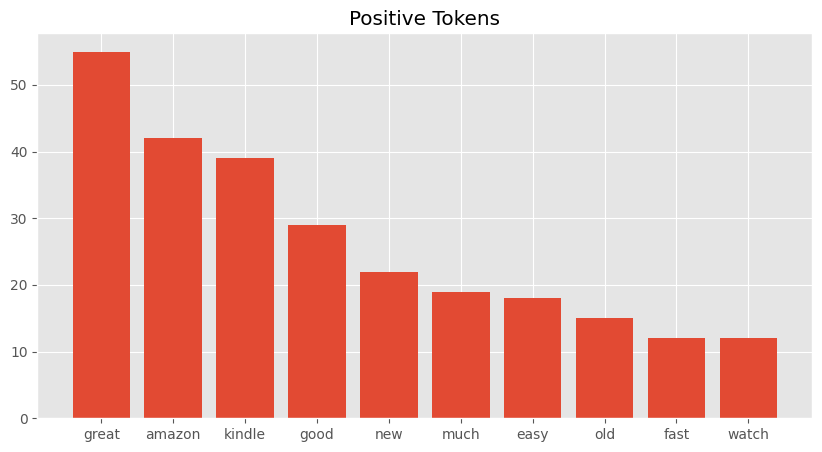

In [49]:
plot_freq(clean_pos_tokens, 'Positive Tokens')

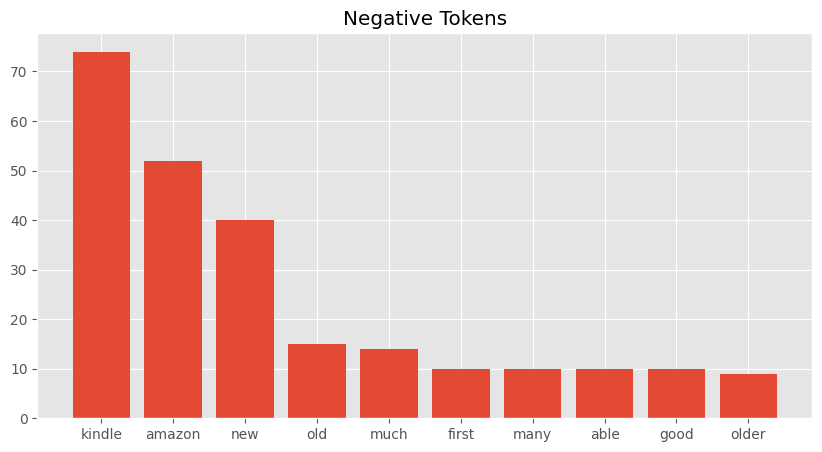

In [50]:
plot_freq(clean_neg_tokens, 'Negative Tokens')

In [51]:
def filterBy_pos(words_list, pos_classes):
    tagged = pos_tag(words_list)
    filtered_words = [word for word, pos in tagged if pos in pos_classes]

    fUnique = sorted(set(filtered_words))
    #print(fUnique[:6])
    return filtered_words

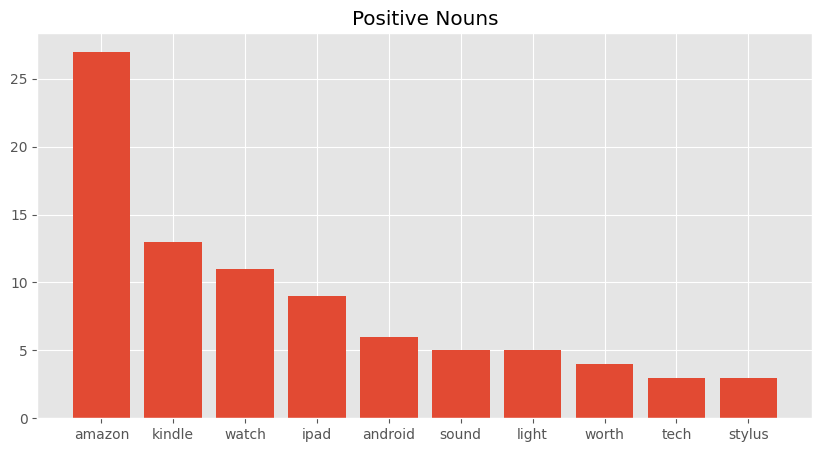

In [52]:
fpos_nouns = filterBy_pos(clean_pos_tokens, ['NN'])

plot_freq(fpos_nouns, 'Positive Nouns')

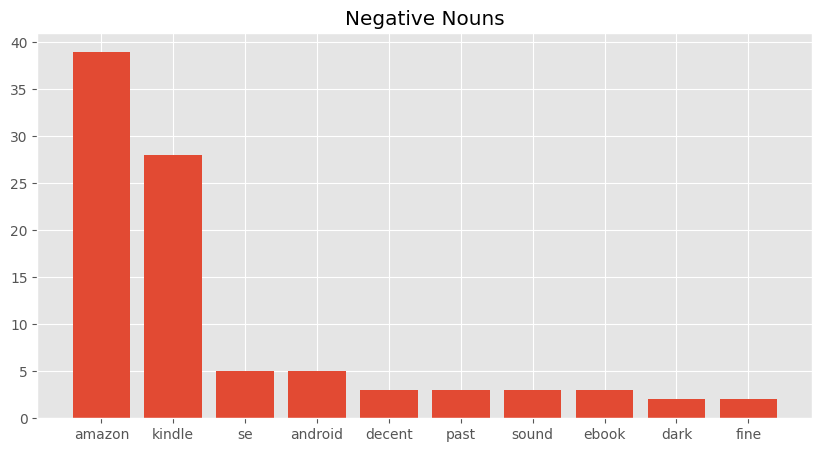

In [53]:
fneg_nouns = filterBy_pos(clean_neg_tokens, ['NN'])

plot_freq(fneg_nouns, 'Negative Nouns')

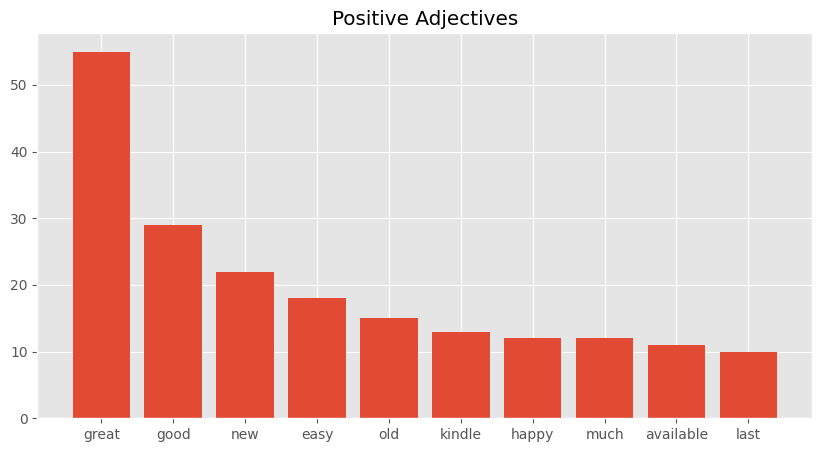

In [54]:
fpos_adj = filterBy_pos(clean_pos_tokens, ['JJ', 'JJR', 'JJS'])

plot_freq(fpos_adj, 'Positive Adjectives')

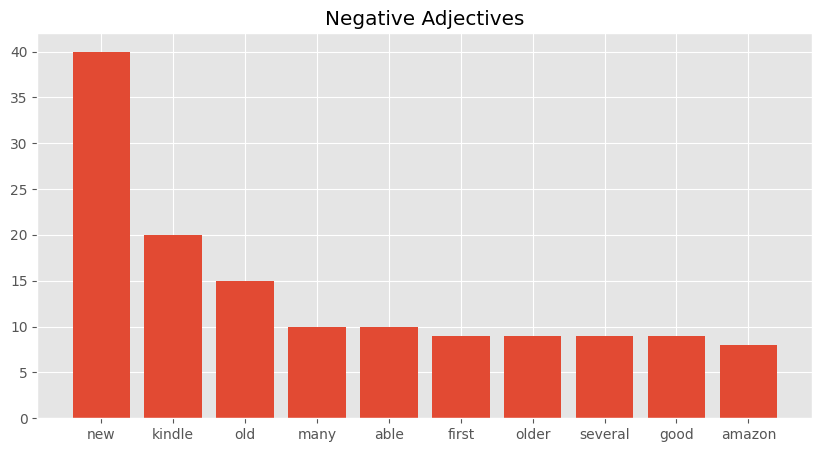

In [55]:
fneg_adj = filterBy_pos(clean_neg_tokens, ['JJ', 'JJR', 'JJS'])

plot_freq(fneg_adj, 'Negative Adjectives')

### Combine and Compare

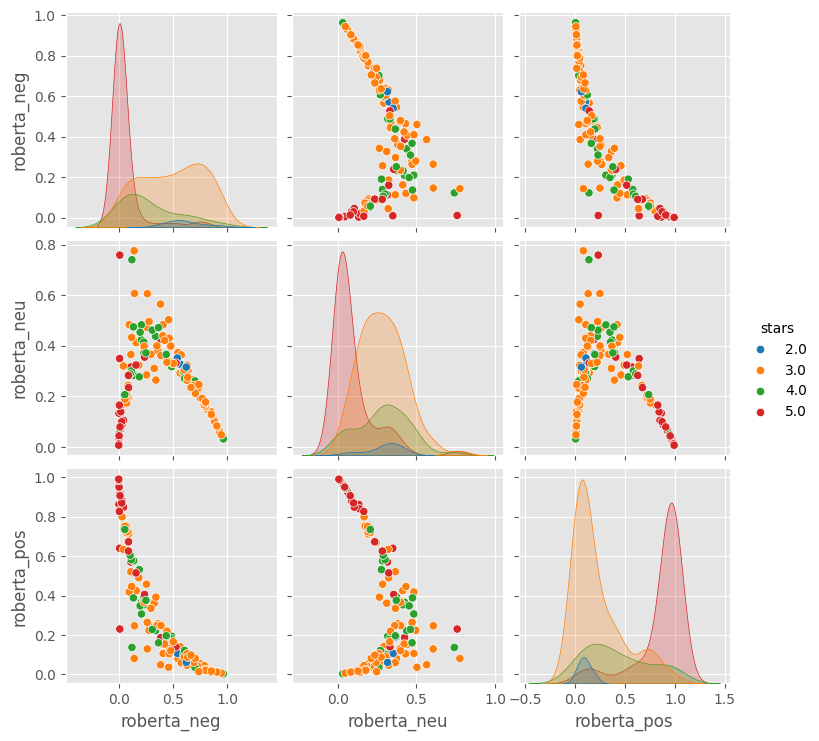

In [56]:
sns.pairplot(data=results_df,
            vars=['roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='stars',
            palette='tab10')
plt.show()

In [57]:
print(results_df.query('stars == 1 or stars == 2') \
    .sort_values('roberta_pos', ascending=False)['text'].values[0])

print(results_df.query('stars == 1 or stars == 2') \
    .sort_values('roberta_pos', ascending=False)["roberta_pos"].values[0]) 


i had a 10" fire tablet since ~2015. it's battery finally got difficult to charge, and i don't see how to change the battery, so i bought a new one. set up was easy, the screen is the same, i was happy until i realized that it will not play videos. the thing will buffer for i don't know how long (have not pushed it past 10 min....). restarting helps but not for long. it's awful to have to restart every 15 min or so when on social media or youtube. i may have to send this thing back.update: a support person called then emailed. which was nice. sadly every email is answered by a different person. tho that may not have made much difference. the first couple of helpers started with the 'do a restart' or 'go read this forum' like i'd been doing. sigh. one person finally suggested that i uninstall and re-install my tablet on my network to address the buffering. weird but i did it and had nearly 3 days of no buffering!! within 2.5 hrs of me emailing the support person my good news, the damn 

In [58]:
print(results_df.query('stars == 3') \
    .sort_values('roberta_neu', ascending=False)['text'].values[1])

print(results_df.query('stars == 3') \
    .sort_values('roberta_neu', ascending=False)['roberta_neu'].values[1])


It worked for one day than the wifi failed return for replacement

0.6069442


In [59]:
print(results_df.query('stars == 5') \
    .sort_values('roberta_neg', ascending=False)['text'].values[0])

print(results_df.query('stars == 5') \
    .sort_values('roberta_neg', ascending=False)["roberta_neg"].values[0]) # the neg value in the pos review(5stars)


I loved this Kindle.  But after a few weeks it started glitching.  I would open a book to read it, and within a few seconds the book would disappear, the screen would go dark, and then a message would flash so fast that it was difficult for me to read.  After repeating this process dozens of times so that I could finally read the message, I was found that the Kindle was informing me that my (actually none of my books) were in my list.  The first time this happened, I reset the Kindle to factory defaults, and then re-downloaded my books.  But a week later the same thing happened again.  I figured I just go bad luck, so I wanted to "replace" the Kindle with an identical one.  But Amazon wouldn't let me do that.  I had to return it and get my money back.  I really don't have complaints about the Kindle; every once in a while you will get a product that doesn't work.  My complaint is with Amazon customer service -- all menu driven, didn't get to talk to a live person, the menu options wer

## Textblob

### Testing deep_translator for translating port -->> eng

In [60]:
tradutor = GoogleTranslator(source= "pt", target= "en")

In [61]:
text = "Eu ODEIO essa música! Mas a letra é muito boa"
traducao = tradutor.translate(text)
blob = TextBlob(traducao)

In [62]:
polarity = blob.sentiment.polarity
subjectivity = blob.sentiment.subjectivity

print(polarity)
print(subjectivity)
print(blob.sentiment)

-0.04500000000000004
0.8400000000000001
Sentiment(polarity=-0.04500000000000004, subjectivity=0.8400000000000001)


In [67]:
df_eng_n = pd.read_csv('datasets/NEGATIVE_B0BHZT5S12.csv', sep=';')
df_eng_p = pd.read_csv('datasets/POSITIVE_B0BHZT5S12.csv', sep=';')

df_eng = (pd.concat([df_eng_n, df_eng_p], ignore_index=True)
     .assign(origem=lambda x: ['negative'] * len(neg_df) + ['positive'] * len(pos_df)))

In [68]:
df_eng.head(3)

,username,title,model,verified,date,region,text,stars,id,origem
0,columbia93,Battery doesn't last very long & forget about ...,Digital Storage Capacity: 32 GBOffer Type: Wit...,Verified Purchase,"April 6, 2024",United States,\nThis is my 3rd Fire 10 Tablet. They have a r...,3.0,B0BHZT5S12,negative
1,Deirdre,Comic Reader Perspective,Digital Storage Capacity: 32 GBOffer Type: Wit...,Verified Purchase,"April 11, 2024",United States,\nI picked this up as an inexpensive Comixolog...,3.0,B0BHZT5S12,negative
2,Paris,It's like a cool toy...,Digital Storage Capacity: 32 GBOffer Type: Wit...,Verified Purchase,"April 18, 2024",United States,\nI have had Samsung Galaxy products for years...,3.0,B0BHZT5S12,negative


In [69]:
translate = lambda x: GoogleTranslator(source= "en", target= "pt").translate(x) if len(x) < 5000 else print('Não foi possível traduzir')

df_port = df_eng.copy()

df_port['text'] = df_eng['text'].apply(translate)
df_port['title'] = df_eng['title'].apply(translate)

Não foi possível traduzir


In [70]:
df_port.head(3)

,username,title,model,verified,date,region,text,stars,id,origem
0,columbia93,A bateria não dura muito e esqueça de usar o c...,Digital Storage Capacity: 32 GBOffer Type: Wit...,Verified Purchase,"April 6, 2024",United States,Este é o meu terceiro tablet Fire 10. Eles têm...,3.0,B0BHZT5S12,negative
1,Deirdre,Perspectiva do leitor de quadrinhos,Digital Storage Capacity: 32 GBOffer Type: Wit...,Verified Purchase,"April 11, 2024",United States,Eu escolhi este como um tablet barato focado e...,3.0,B0BHZT5S12,negative
2,Paris,É como um brinquedo legal...,Digital Storage Capacity: 32 GBOffer Type: Wit...,Verified Purchase,"April 18, 2024",United States,"Eu tenho produtos Samsung Galaxy há anos, mas ...",3.0,B0BHZT5S12,negative


In [71]:
df_port = df_port.dropna()

In [72]:
def sentences_tokenization(text):
  sentences = []
  blob = TextBlob(text)
  for sentence in blob.sentences:
    sentences.append(str(sentence))

  return sentences

In [73]:
df_port.loc[:, 'sentences'] = df_port['text'].apply(sentences_tokenization)

In [74]:
df_port.loc[:, 'token_pt'] = df_port['text'].apply(sentences_tokenization)

#### Using polarity to distinguish bad/good sentiments

In [75]:
def sentiment_analysis(sentences):
  sentiments = []
  for sentence in sentences:
    blob = TextBlob(sentence)
    sentiment = blob.sentiment.polarity
    sentiments.append(sentiment)

  return sentiments

In [76]:
df_port.loc[:, 'sentences_sentiments'] = df_port['token_pt'].apply(sentiment_analysis)

In [77]:
df_port.loc[:, 'positive_sentences'] = df_port.apply(lambda x: [frase for frase, sentimento in zip(x['sentences'], x['sentences_sentiments']) if sentimento > 0], axis=1)

In [78]:
df_port.loc[:, 'negative_sentences'] = df_port.apply(lambda x: [frase for frase, sentimento in zip(x['sentences'], x['sentences_sentiments']) if sentimento < 0], axis=1)

In [79]:
df_port.head(3)

,username,title,model,verified,date,region,text,stars,id,origem,sentences,token_pt,sentences_sentiments,positive_sentences,negative_sentences
0,columbia93,A bateria não dura muito e esqueça de usar o c...,Digital Storage Capacity: 32 GBOffer Type: Wit...,Verified Purchase,"April 6, 2024",United States,Este é o meu terceiro tablet Fire 10. Eles têm...,3.0,B0BHZT5S12,negative,"[Este é o meu terceiro tablet Fire 10., Eles t...","[Este é o meu terceiro tablet Fire 10., Eles t...","[0.0, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",[Eles têm um problema real de sustentabilidade...,[]
1,Deirdre,Perspectiva do leitor de quadrinhos,Digital Storage Capacity: 32 GBOffer Type: Wit...,Verified Purchase,"April 11, 2024",United States,Eu escolhi este como um tablet barato focado e...,3.0,B0BHZT5S12,negative,[Eu escolhi este como um tablet barato focado ...,[Eu escolhi este como um tablet barato focado ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",[],[]
2,Paris,É como um brinquedo legal...,Digital Storage Capacity: 32 GBOffer Type: Wit...,Verified Purchase,"April 18, 2024",United States,"Eu tenho produtos Samsung Galaxy há anos, mas ...",3.0,B0BHZT5S12,negative,"[Eu tenho produtos Samsung Galaxy há anos, mas...","[Eu tenho produtos Samsung Galaxy há anos, mas...","[0.0, 0.0, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[Definitivamente não é Android, mas é legal., ...",[]


#### By the sentiments prediction, we can consider that the model does not work as well for portuguese reviews as it does in english.

In [80]:
positive_text = [str(frase) for frase in df_port['positive_sentences']]
positive_text = ' '.join(positive_text)

negative_text = [str(frase) for frase in df_port['negative_sentences']]
negative_text = ' '.join(negative_text)

In [81]:
stopwords = nltk.corpus.stopwords.words('portuguese')
punctuation = string.punctuation

In [82]:
positive_text = positive_text.lower()
negative_text = negative_text.lower()

In [83]:
wp = Word(positive_text)
lemma_pos = TextBlob(positive_text)
" ". join([w.lemmatize() for w in lemma_pos.words])

wn = Word(negative_text)
lemma_neg = TextBlob(negative_text)
" ". join([w.lemmatize() for w in lemma_neg.words])

"'eu precisava substituir um tablet do tipo android e optei pelo amazon fire apenas com base no fato de que meu aplicativo principal é o audible imaginando que um serviço da amazon como o audible funcionaria muito bem em seu próprio tablet 'eu tenho a base de carregamento sem fio e agora ela não vale nada para isso o segundo representante foi rude e indiferente o representante rude e desdenhoso meio que me irritou e depois de fazer algumas pesquisas vejo que outros tiveram problemas com ele 'minha senha funcionou ma há muito para entender para torná-la totalmente operável exceto meu jogo 7 little word 'mas na black friday 79 é uma boa compra 'você não pode aumentá-los ou ajustar qualquer tipo de base ou problema 'não há aplicativos suficientes minha filha odeia ma ainda tenho mais alguns pagamentos o preço é justo especialmente durante a vendas do prime day ou black friday então por que não 'emparelhado com um mouse e teclado bluetooth você pode essencialmente usar o tablet como um “ t

In [84]:
pos_tokens = word_tokenize(positive_text)
neg_tokens = word_tokenize(negative_text)

In [85]:
pos_tokens = [word for word in pos_tokens if word not in stopwords and word ]
neg_tokens = [word for word in neg_tokens if word not in stopwords and word ]

In [86]:
clean_pos_tokens = []
clean_neg_tokens = []

In [87]:
for token in pos_tokens:
    clean_token = ''.join(char for char in token if char not in punctuation)
    if clean_token:
        clean_pos_tokens.append(clean_token)

for token in neg_tokens:
    clean_token = ''.join(char for char in token if char not in punctuation)
    if clean_token:
        clean_neg_tokens.append(clean_token)

In [88]:
print(clean_pos_tokens[:6])

['eles', 'têm', 'problema', 'real', 'sustentabilidade', 'morrem']


In [89]:
print(clean_neg_tokens[:6])

['eu', 'precisava', 'substituir', 'tablet', 'tipo', 'android']


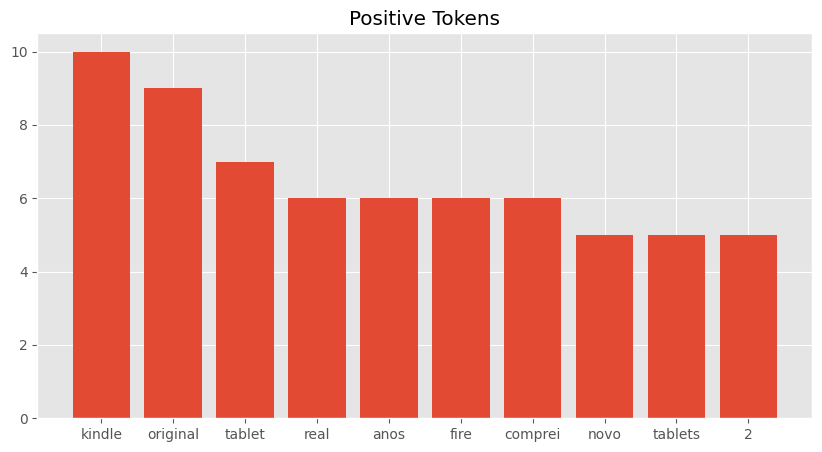

In [90]:
plot_freq(clean_pos_tokens, 'Positive Tokens')

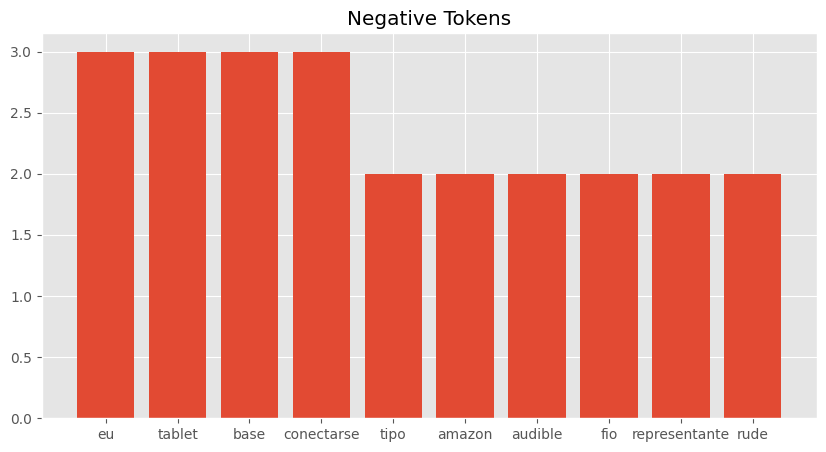

In [91]:
plot_freq(clean_neg_tokens, 'Negative Tokens')

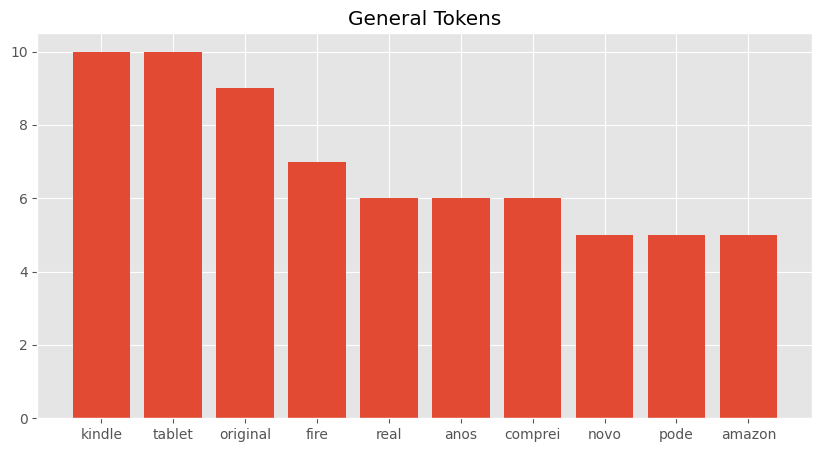

In [92]:
plot_freq(clean_pos_tokens + clean_neg_tokens, 'General Tokens')

In [94]:
negative_postag = nltk.tag.pos_tag(clean_neg_tokens)
positive_postag = nltk.tag.pos_tag(clean_pos_tokens)

df_port_postag = pd.DataFrame(negative_postag+positive_postag, columns=['word', 'postag'])

df_port_postag.head()

,word,postag
0,eu,NN
1,precisava,NN
2,substituir,JJ
3,tablet,NN
4,tipo,NN


In [95]:
adjectives = []

for i in range(len(df_port_postag['postag'])):
    if df_port_postag['postag'][i] in ['JJ', 'JJR', 'JJS']:
        adjectives.append(df_port_postag['word'][i])

adjectives[:6]

['substituir', 'android', 'principal', 'audible', 'audible', 'eu']

## Comparing with NRC Lexicon

In [98]:
df_port.head(3)

,username,title,model,verified,date,region,text,stars,id,origem,sentences,token_pt,sentences_sentiments,positive_sentences,negative_sentences
0,columbia93,A bateria não dura muito e esqueça de usar o c...,Digital Storage Capacity: 32 GBOffer Type: Wit...,Verified Purchase,"April 6, 2024",United States,Este é o meu terceiro tablet Fire 10. Eles têm...,3.0,B0BHZT5S12,negative,"[Este é o meu terceiro tablet Fire 10., Eles t...","[Este é o meu terceiro tablet Fire 10., Eles t...","[0.0, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",[Eles têm um problema real de sustentabilidade...,[]
1,Deirdre,Perspectiva do leitor de quadrinhos,Digital Storage Capacity: 32 GBOffer Type: Wit...,Verified Purchase,"April 11, 2024",United States,Eu escolhi este como um tablet barato focado e...,3.0,B0BHZT5S12,negative,[Eu escolhi este como um tablet barato focado ...,[Eu escolhi este como um tablet barato focado ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",[],[]
2,Paris,É como um brinquedo legal...,Digital Storage Capacity: 32 GBOffer Type: Wit...,Verified Purchase,"April 18, 2024",United States,"Eu tenho produtos Samsung Galaxy há anos, mas ...",3.0,B0BHZT5S12,negative,"[Eu tenho produtos Samsung Galaxy há anos, mas...","[Eu tenho produtos Samsung Galaxy há anos, mas...","[0.0, 0.0, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[Definitivamente não é Android, mas é legal., ...",[]


In [99]:
df_port = df_port.dropna()

In [100]:
texts = [text for text in df_port['text']] # putting reviews in a list

emotions = []

for text in texts:  # Here we give the song the average emotion in it

    e = NRCLex(text)
    if e.affect_list:  # Verifica se a lista não está vazia
        mode = max(e.affect_list, key=Counter(e.affect_list).get)
        emotions.append(mode)
    else:
        ind = df_port.loc[df_port['text'] == text].index
        df_port = df_port.drop(ind) # remove songs wich do not contain valid lyrics

df_port['Emotion'] = emotions

In [102]:
df_port[['title', 'text', 'sentences', 'token_pt', 'sentences_sentiments', 'positive_sentences', 'negative_sentences', 'Emotion']].head(3)

,title,text,sentences,token_pt,sentences_sentiments,positive_sentences,negative_sentences,Emotion
0,A bateria não dura muito e esqueça de usar o c...,Este é o meu terceiro tablet Fire 10. Eles têm...,"[Este é o meu terceiro tablet Fire 10., Eles t...","[Este é o meu terceiro tablet Fire 10., Eles t...","[0.0, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",[Eles têm um problema real de sustentabilidade...,[],positive
1,Perspectiva do leitor de quadrinhos,Eu escolhi este como um tablet barato focado e...,[Eu escolhi este como um tablet barato focado ...,[Eu escolhi este como um tablet barato focado ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",[],[],negative
2,É como um brinquedo legal...,"Eu tenho produtos Samsung Galaxy há anos, mas ...","[Eu tenho produtos Samsung Galaxy há anos, mas...","[Eu tenho produtos Samsung Galaxy há anos, mas...","[0.0, 0.0, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[Definitivamente não é Android, mas é legal., ...",[],positive


In [103]:
mean_emotionPor = df_port['Emotion'].value_counts()

mean_emotionPor

Emotion
positive    29
negative     7
fear         5
anger        5
trust        4
Name: count, dtype: int64

### Repeating the process for the english version

In [104]:
df_eng = df_eng.dropna()

In [105]:
texts = [text for text in df_eng['text']] # putting reviews in a list

emotions = []

for text in texts:  # Here we give the song the average emotion in it

    e = NRCLex(text)
    if e.affect_list:  # Verifica se a lista não está vazia
        mode = max(e.affect_list, key=Counter(e.affect_list).get)
        emotions.append(mode)
    else:
        ind = df_eng.loc[df_eng['text'] == text].index
        df_eng = df_eng.drop(ind) # remove songs wich do not contain valid lyrics

df_eng['Emotion'] = emotions

In [106]:
mean_emotionEng = df_eng['Emotion'].value_counts()
mean_emotionEng

Emotion
positive        101
anticipation     30
negative         20
trust            12
fear              8
joy               7
sadness           6
anger             4
Name: count, dtype: int64

- By that we notice that in portuguese he had difficulties classifying the fellings, again because english is most used in libs 

### Results

In [107]:
results_df.head(3)

,Id,roberta_neg,roberta_neu,roberta_pos,username,title,model,verified,date,region,text,stars,product_id,origem
0,0,0.922657,0.068516,0.008828,KevinT,Not enough apps,Digital Storage Capacity: 32 GBOffer Type: Wit...,Verified Purchase,"April 11, 2024",United States,"\nNot enough apps, my daughter hates it but I ...",3.0,B0BHZT5S12,negative
1,1,0.477187,0.392493,0.130321,SRK,Okay for its price,Digital Storage Capacity: 32 GBOffer Type: Wit...,Verified Purchase,"December 29, 2023",United States,\nPros -1. Lower price compared to iPad.2. Has...,3.0,B0BHZT5S12,negative
2,3,0.015919,0.130102,0.853979,C C,I love my Kindel,Digital Storage Capacity: 32 GBOffer Type: Wit...,Verified Purchase,"May 2, 2024",United States,\nIs only one thing it is not blue tooth I lik...,3.0,B0BHZT5S12,negative


In [108]:
print(results_df.query('stars == 2') \
    .sort_values('roberta_pos', ascending=False)['text'].values[0])

print(results_df.query('stars == 2') \
    .sort_values('roberta_pos', ascending=False)['roberta_pos'].values[0])


i had a 10" fire tablet since ~2015. it's battery finally got difficult to charge, and i don't see how to change the battery, so i bought a new one. set up was easy, the screen is the same, i was happy until i realized that it will not play videos. the thing will buffer for i don't know how long (have not pushed it past 10 min....). restarting helps but not for long. it's awful to have to restart every 15 min or so when on social media or youtube. i may have to send this thing back.update: a support person called then emailed. which was nice. sadly every email is answered by a different person. tho that may not have made much difference. the first couple of helpers started with the 'do a restart' or 'go read this forum' like i'd been doing. sigh. one person finally suggested that i uninstall and re-install my tablet on my network to address the buffering. weird but i did it and had nearly 3 days of no buffering!! within 2.5 hrs of me emailing the support person my good news, the damn 

In [109]:
print(results_df.query('stars == 3') \
    .sort_values('roberta_neu', ascending=False)['text'].values[1])

print(results_df.query('stars == 3') \
    .sort_values('roberta_neu', ascending=False)['roberta_neu'].values[1])


It worked for one day than the wifi failed return for replacement

0.6069442


In [110]:
print(results_df.query('stars == 5') \
    .sort_values('roberta_neg', ascending=False)['text'].values[0])

print(results_df.query('stars == 5') \
    .sort_values('roberta_neg', ascending=False)['roberta_neg'].values[0])


I loved this Kindle.  But after a few weeks it started glitching.  I would open a book to read it, and within a few seconds the book would disappear, the screen would go dark, and then a message would flash so fast that it was difficult for me to read.  After repeating this process dozens of times so that I could finally read the message, I was found that the Kindle was informing me that my (actually none of my books) were in my list.  The first time this happened, I reset the Kindle to factory defaults, and then re-downloaded my books.  But a week later the same thing happened again.  I figured I just go bad luck, so I wanted to "replace" the Kindle with an identical one.  But Amazon wouldn't let me do that.  I had to return it and get my money back.  I really don't have complaints about the Kindle; every once in a while you will get a product that doesn't work.  My complaint is with Amazon customer service -- all menu driven, didn't get to talk to a live person, the menu options wer

In [113]:
df_eng_view = df_eng.drop(columns=['origem', 'verified', 'date', 'region', 'model'])

df_eng_view.head(3)

,username,title,text,stars,id,Emotion
0,columbia93,Battery doesn't last very long & forget about ...,\nThis is my 3rd Fire 10 Tablet. They have a r...,3.0,B0BHZT5S12,positive
1,Deirdre,Comic Reader Perspective,\nI picked this up as an inexpensive Comixolog...,3.0,B0BHZT5S12,positive
2,Paris,It's like a cool toy...,\nI have had Samsung Galaxy products for years...,3.0,B0BHZT5S12,positive


## Fontes/Ideias

Análise de sentimentos em português utilizando Pytorch e Python

* [Parte 1](https://medium.com/data-hackers/an%C3%A1lise-de-sentimentos-em-portugu%C3%AAs-utilizando-pytorch-e-python-91a232165ec0)

* [Parte 2](https://medium.com/data-hackers/deploy-de-um-modelo-de-an%C3%A1lise-de-sentimentos-como-uma-rest-api-878c175ad24f)

---

[Construindo um analisador de sentimentos em python](https://acadianschool.com.br/construindo-um-analisador-de-sentimentos-em-python/)

---

[AIpp](https://github.com/TailUFPB/AIpp/tree/main)

---

[tradutor de texto em python](https://www.hashtagtreinamentos.com/tradutor-de-texto-em-python#:~:text=Utilizaremos%20a%20biblioteca%20Deep%2Dtranslator,podemos%20fazer%20no%20pr%C3%B3prio%20site.)

---

[swiftclassifier](https://github.com/biabcaval/swiftclassifier/tree/main)

In [ ]:
# tentar pegar apenas adjetivos para retornar palavras mais utilizadas
# retornar a média das reviews
# criar interação com usuário